In [2]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
gpu_index = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_index
os.environ['HF_HOME'] = '../huggingface_cache/'      # Cache directory for huggingface.
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
import sys
sys.path.sort()
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [4]:
import torch
import torchvision
from transformers import AutoConfig, AutoFeatureExtractor
from transformers.models.vit.modeling_vit import ViTLayer
from transformers.models.audio_spectrogram_transformer.modeling_audio_spectrogram_transformer import ASTLayer
import itertools
import dataclasses
from tqdm import tqdm
import copy
from IPython.display import clear_output

In [5]:
import random
import numpy as np

# Set a seed value
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

gen = torch.Generator()
gen.manual_seed(seed)

In [6]:
from data_manager import get_simple_transform, get_img_transform, AdvanceDataset, seed_worker
from model import ImageEncoder, AudioEncoder, ProjectionHead, PredictionHead, SupAdvance, prep_img_model_prog, prep_audio_model_prog
from train_val_manager import train_sup_advance, val_sup_advance, val_sup_advance_metrics, comp_cost, get_model_size
import federated_learning as fl
from configs import PROG_SUP_ADVANCE_FL
import utils

In [7]:
CFG = PROG_SUP_ADVANCE_FL.Config()
print(dataclasses.asdict(CFG))

{'device': device(type='cuda'), 'train_img_dir': '../datasets/ADVANCE/train/vision', 'train_audio_dir': '../datasets/ADVANCE/train/sound', 'val_img_dir': '../datasets/ADVANCE/test/vision', 'val_audio_dir': '../datasets/ADVANCE/test/sound', 'img_size': 224, 'batch_size': 16, 'num_workers': 2, 'prefetch_factor': 2, 'img_enc_name': 'WinKawaks/vit-tiny-patch16-224', 'img_feat_dim': 192, 'audio_enc_name': 'bookbot/distil-ast-audioset', 'audio_feat_dim': 768, 'hidden_dim': 4096, 'projection_dim': 256, 'dropout': 0.1, 'num_layers': 3, 'pred_hidden_dim': 256, 'pred_num_layers': 2, 'pred_dropout': 0.1, 'base_head_lr': 0.0001, 'base_img_enc_lr': 1e-07, 'base_audio_enc_lr': 1e-05, 'base_pred_head_lr': 0.0001, 'img_enc_lr': 6.25e-09, 'audio_enc_lr': 6.25e-07, 'head_lr': 6.25e-06, 'pred_head_lr': 6.25e-06, 'weight_decay': 1e-06, 'temperature': 0.05, 'num_local_epochs': 3, 'num_clients': 40, 'active_num_clients': None, 'beta': 0.5, 'set_num': '120_lh11_lr', 'num_stages': 6, 'num_epochs': (0, 0, 0, 2

In [53]:
save_dir = os.path.join(
    './output/PROG_SUP_ADVANCE_FL/', 
    'b_{}_nc_{}_beta_{}'.format(
        CFG.batch_size,
        CFG.num_clients,
        CFG.beta,
    )
)
save_dir = '{}_anc_{}'.format(save_dir, CFG.active_num_clients) if CFG.active_num_clients else save_dir
save_dir = '{}_set_{}'.format(save_dir, CFG.set_num)

if seed != 42:
    save_dir = '{}_seed_{}'.format(save_dir, seed)

os.makedirs(save_dir, exist_ok=True)
print(save_dir)

base_pretrained_dir = './pretrained_weights'
img_pretrained_dir = os.path.join(base_pretrained_dir, CFG.img_enc_name.split('/')[-1])
audio_pretrained_dir = os.path.join(base_pretrained_dir, CFG.audio_enc_name.split('/')[-1])

./output/PROG_SUP_ADVANCE_FL/b_16_nc_40_beta_5_anc_30_set_120_lh11_lr


In [10]:
# Prepare data.
simple_transform = get_simple_transform(img_size=CFG.img_size)
img_transform = get_img_transform(img_size=CFG.img_size)
feature_extractor = AutoFeatureExtractor.from_pretrained(CFG.audio_enc_name, do_normalize=True)

In [9]:
# Define client data.
client_data_dir = '../datasets/ADVANCE/c_{}_beta_{}_train/'.format(CFG.num_clients, CFG.beta)
print('client_data_dir:', client_data_dir)
client_loaders = []
for client_idx in range(CFG.num_clients):
    # client_dataset = torch.utils.data.Subset(train_dataset, range(img_idx, img_idx + num_img))
    client_dataset = AdvanceDataset(
        img_dir=os.path.join(client_data_dir, str(client_idx), 'vision'),
        audio_dir=os.path.join(client_data_dir, str(client_idx), 'sound'),
        feature_extractor=feature_extractor, 
        img_transform=img_transform, 
        return_label=True,
    )
    print(client_idx, ':', len(client_dataset))

    client_loader = torch.utils.data.DataLoader(
        client_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        drop_last=True,                    
        num_workers=CFG.num_workers,
        persistent_workers=True,
        pin_memory=True,
        prefetch_factor=CFG.prefetch_factor,
        worker_init_fn=seed_worker,
        generator=gen,
    )
    client_loaders.append(client_loader)
    # img_idx += num_img

client_data_dir: ../datasets/ADVANCE/c_10_beta_0.5_train/
0 : 199
1 : 444
2 : 286
3 : 412
4 : 434
5 : 231
6 : 257
7 : 594
8 : 680
9 : 519


In [11]:
val_dataset = AdvanceDataset(
    img_dir=CFG.val_img_dir, 
    audio_dir=CFG.val_audio_dir, 
    feature_extractor=feature_extractor, 
    img_transform=simple_transform, 
    return_label=True,
)
print('len(val_dataset):', len(val_dataset))
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=CFG.num_workers,
    persistent_workers=True,
    pin_memory=True,
    prefetch_factor=CFG.prefetch_factor,
)

len(val_dataset): 1019


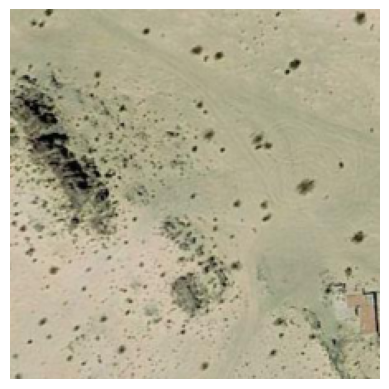

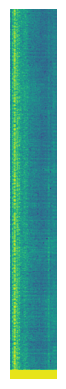

tensor(10)


In [11]:
dataiter = iter(client_loaders[0])
img, audio, label = next(dataiter)

utils.show_img_tensor(img[0])
utils.show_img_tensor(audio[0])
print(label[0])

In [54]:
# Initialize encoder configurations.
img_enc_config = AutoConfig.from_pretrained(CFG.img_enc_name)
audio_enc_config = AutoConfig.from_pretrained(CFG.audio_enc_name)

img_enc_config.num_hidden_layers = 0
audio_enc_config.num_hidden_layers = 0

In [55]:
# Encoders.
lw_img_enc = ImageEncoder(config=img_enc_config)
lw_audio_enc = AudioEncoder(config=audio_enc_config)

# Projection heads.
img_proj_head = ProjectionHead(CFG.img_feat_dim, CFG.hidden_dim, CFG.projection_dim, CFG.num_layers, CFG.dropout)
audio_proj_head = ProjectionHead(CFG.audio_feat_dim, CFG.hidden_dim, CFG.projection_dim, CFG.num_layers, CFG.dropout)

# Prediction head.
num_classes = len(val_dataset.classes)
pred_head = PredictionHead(2*CFG.projection_dim, CFG.pred_hidden_dim, num_classes, CFG.pred_num_layers, CFG.pred_dropout)

In [56]:
# For logging model performance.
metric_keys = ['train_loss', 'test_loss', 'train_acc', 'test_acc', 'restart_stage', 'restart_epoch', 'model_size']
_, performance_log = utils.get_performance_loggers(metric_keys)
performance_log['lr'] = {}

client_log = {}
for client_idx in range(CFG.num_clients):
    client_log[client_idx] = {}

In [57]:
# Automatic resuming.
start_stage = 0
start_epoch = 0
skip_prep_model = False

log_path = os.path.join(save_dir, 'performance_log.pickle')
client_log_path = os.path.join(save_dir, 'client_log.pickle')
ckpt_path = os.path.join(save_dir, 'ckpt_bundle.pth')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
    client_log = utils.load_pickle(client_log_path)
    ckpt_bundle = torch.load(ckpt_path)
    
    start_stage = ckpt_bundle['stage']
    start_epoch = ckpt_bundle['epoch'] + 1     # 1 is added since we save after finishing the epoch. So we start at next.

    performance_log['restart_stage'].append(start_stage)
    performance_log['restart_epoch'].append(start_epoch)
    
    # Prepare encoders for this stage. 
    for num_img_layers, num_audio_layers in zip(CFG.num_img_layers[:start_stage+1], CFG.num_audio_layers[:start_stage+1]):
        lw_img_enc = prep_img_model_prog(lw_img_enc, num_img_layers, ViTLayer, img_pretrained_dir)
        lw_audio_enc = prep_audio_model_prog(lw_audio_enc, num_audio_layers, ASTLayer, audio_pretrained_dir)
    
    # Supervised model.    
    sup_model = SupAdvance(lw_img_enc, lw_audio_enc, img_proj_head, audio_proj_head, pred_head)
    sup_model.load_state_dict(ckpt_bundle['sup_model'])
    sup_model = sup_model.to(CFG.device)

    skip_prep_model = True

/tmp/ipykernel_223005/2482631534.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_bundle = torch.load(ckpt_path)


In [58]:
%%time
for stage in range(start_stage, CFG.num_stages):
    clear_output(wait=True)
    
    utils.print_separator(text='Stage: {} / {}'.format(stage + 1, CFG.num_stages))

    # Parameters for this stage.
    num_epochs = CFG.num_epochs[stage]
    num_img_layers = CFG.num_img_layers[stage]
    num_audio_layers = CFG.num_audio_layers[stage]
    if CFG.stage_lr:
        CFG.img_enc_lr = CFG.stage_img_lr[stage] * CFG.batch_size / 256 
        CFG.audio_enc_lr = CFG.stage_audio_lr[stage] * CFG.batch_size / 256
        CFG.head_lr = CFG.stage_head_lr[stage] * CFG.batch_size / 256
        CFG.pred_head_lr = CFG.stage_pred_head_lr[stage] * CFG.batch_size / 256
        
    # Prepare model for a new stage.
    # For automatic resuming training, model preparation is done above and skipped here.
    if not skip_prep_model:
        # Prepare encoders for this stage. 
        lw_img_enc = prep_img_model_prog(lw_img_enc, num_img_layers, ViTLayer, img_pretrained_dir)
        lw_audio_enc = prep_audio_model_prog(lw_audio_enc, num_audio_layers, ASTLayer, audio_pretrained_dir)

        # Supervised model.
        sup_model = SupAdvance(lw_img_enc, lw_audio_enc, img_proj_head, audio_proj_head, pred_head)
        sup_model = sup_model.to(CFG.device)

        start_epoch = 0
    skip_prep_model = False

    # Training.
    for epoch in range(start_epoch, num_epochs):
        utils.print_separator(text='Epoch: {} / {}'.format(epoch + 1, num_epochs))

        val_result_dict = val_sup_advance(sup_model, val_loader, CFG)
        performance_log['test_loss'].append(val_result_dict['loss'])
        performance_log['test_acc'].append(val_result_dict['acc'])
        performance_log['model_size'].append(get_model_size(sup_model))    # Model size for sanity check.

        # Local training.
        if CFG.active_num_clients:
            active_clients = np.random.choice(range(CFG.num_clients), CFG.active_num_clients, replace=False)
            active_clients.sort()
        else:
            active_clients = range(CFG.num_clients)

        client_updates = dict()
        for client_idx in active_clients:
            torch.cuda.empty_cache()
            print('client:', client_idx)

            local_model = copy.deepcopy(sup_model)
            local_loader = client_loaders[client_idx]
            
            # Optimizer.
            params = [
                {'params': filter(lambda p: p.requires_grad, local_model.img_encoder.parameters()), 'lr': CFG.img_enc_lr, 'name': 'img_enc'},
                {'params': filter(lambda p: p.requires_grad, local_model.audio_encoder.parameters()), 'lr': CFG.audio_enc_lr, 'name': 'audio_enc'},
                {'params': itertools.chain(
                    filter(lambda p: p.requires_grad, local_model.img_proj_head.parameters()),
                    filter(lambda p: p.requires_grad, local_model.audio_proj_head.parameters()),
                ), 'lr': CFG.head_lr, 'weight_decay': CFG.weight_decay, 'name': 'proj_head'},
                {'params': filter(lambda p: p.requires_grad, local_model.pred_head.parameters()), 'lr': CFG.pred_head_lr, 'name': 'pred_head'},
            ]
            local_optimizer = torch.optim.AdamW(params)

            # Local training loop.
            for local_epoch in range(CFG.num_local_epochs):
                gpu_time, gpu_mem, train_result_dict = comp_cost(
                    gpu_index, train_sup_advance, local_model, local_loader, local_optimizer, CFG
                )

                # Log for the first client. It is the same for all clients.
                if client_idx == 0:
                    for param_group in local_optimizer.param_groups:
                        performance_log['lr'].setdefault(param_group['name'], list()).extend(train_result_dict[param_group['name']])

                # Log local results.
                client_log[client_idx].setdefault('gpu_time', list()).append(gpu_time)
                client_log[client_idx].setdefault('gpu_mem', list()).append(gpu_mem)
                client_log[client_idx].setdefault('train_loss', list()).append(train_result_dict['loss'])
                client_log[client_idx].setdefault('train_acc', list()).append(train_result_dict['acc'])

            # To calculate global weights and statistics.
            client_updates.setdefault('local_weights', list()).append(local_model.state_dict())
            client_updates.setdefault('num_samples', list()).append(len(local_loader.dataset))
            client_updates.setdefault('train_loss', list()).append(client_log[client_idx]['train_loss'][-1]) # Last loss from the client.
            client_updates.setdefault('train_acc', list()).append(client_log[client_idx]['train_acc'][-1]) # Last accuracy from the client.

        # Aggregation.
        glob_weights = fl.weighted_averaging(client_updates['local_weights'], client_updates['num_samples'])
        sup_model.load_state_dict(glob_weights)
        performance_log['train_loss'].append(sum(client_updates['train_loss'])/len(client_updates['train_loss']))
        performance_log['train_acc'].append(sum(client_updates['train_acc'])/len(client_updates['train_acc']))

        # Save latest check point.
        if (epoch + 1) % CFG.save_epoch == 0:
            ckpt_bundle = {
                'sup_model': sup_model.state_dict(),
            }
            torch.save(ckpt_bundle, ckpt_path)
            utils.save_pickle(log_path, performance_log)
            utils.save_pickle(client_log_path, client_log)
            clear_output(wait=True)
    
        for key in metric_keys:
            if len(performance_log[key]) > 0:
                print(key, '\t:', performance_log[key][-1])


 ==================== Stage: 6 / 6 ====================

CPU times: user 1.3 ms, sys: 0 ns, total: 1.3 ms
Wall time: 883 μs


In [59]:
ckpt_bundle = {
    'sup_model': sup_model.state_dict(),
    'stage': stage,
    'epoch': CFG.num_epochs[stage] - 1,
}
torch.save(ckpt_bundle, ckpt_path)
utils.save_pickle(log_path, performance_log)
utils.save_pickle(client_log_path, client_log)

In [60]:
torch.save(sup_model.state_dict(), os.path.join(save_dir, 'sup_model.pth'))

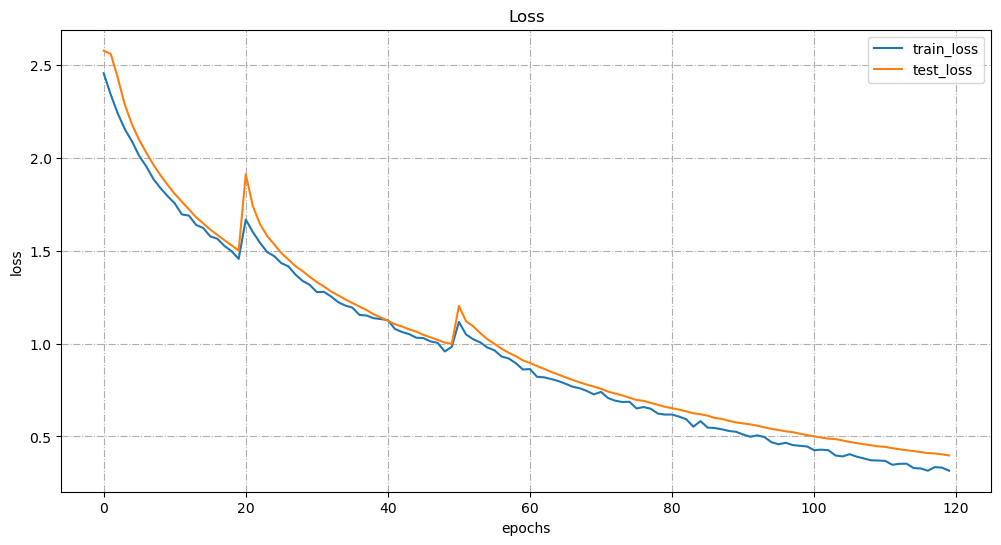

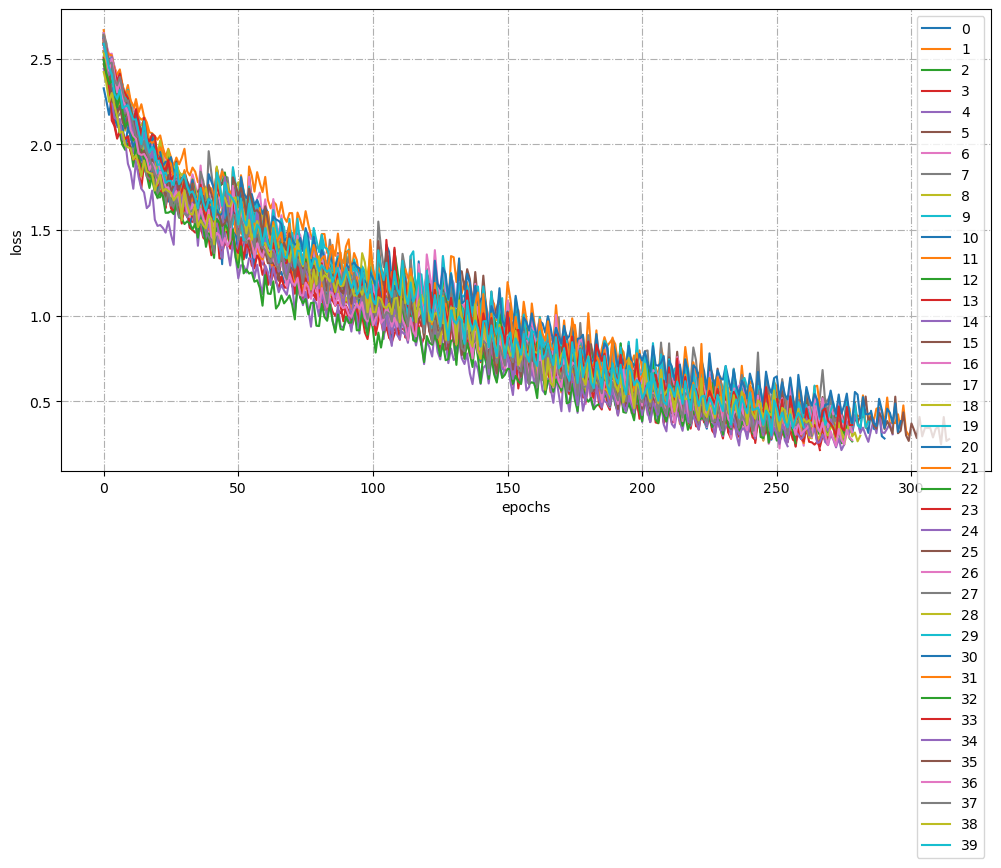

In [61]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = ['train_loss', 'test_loss']
data_list = [performance_log['train_loss'], performance_log['test_loss']]
utils.save_plot(data_list, loss_plot_config)


client_log = utils.load_pickle(client_log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'client_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = [client_idx for client_idx in range(CFG.num_clients)]
data_list = [client_log[client_idx]['train_loss'] for client_idx in range(CFG.num_clients)]
utils.save_plot(data_list, loss_plot_config)

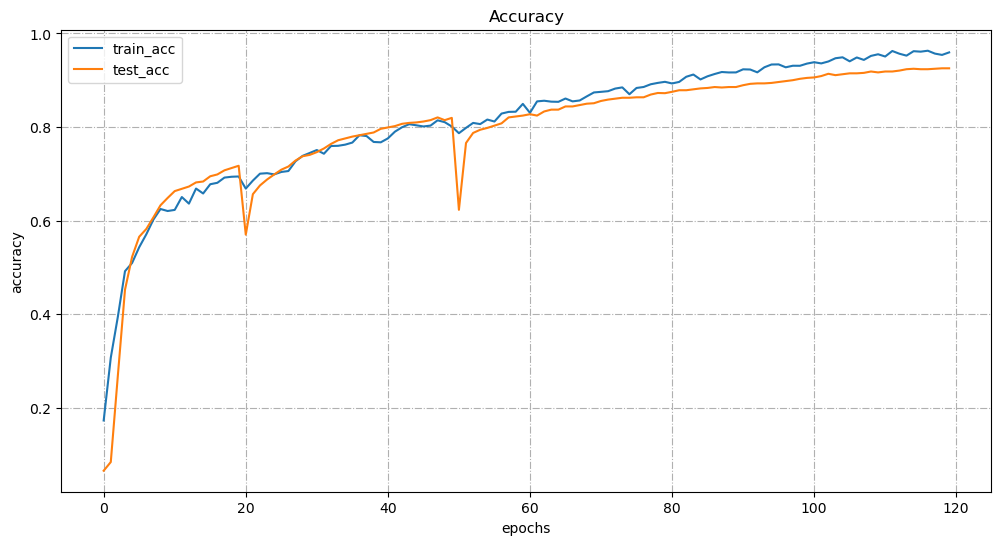

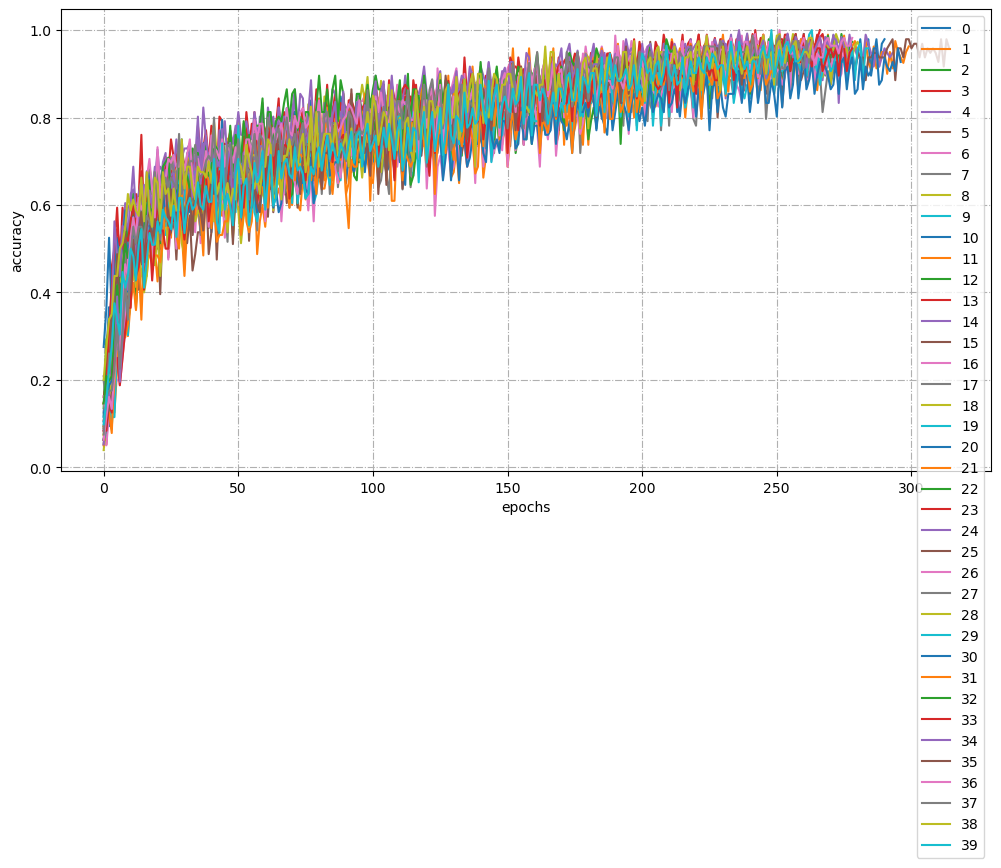

In [62]:
acc_plot_config = utils.ACC_PLOT_CONFIG.copy()
acc_plot_config['figsize'] = (12, 6)
acc_plot_config['save_dir'] = os.path.join(save_dir, 'acc.png')
acc_plot_config['show_img'] = True
acc_plot_config['xlabel'] = 'epochs'
acc_plot_config['labels'] = ['train_acc', 'test_acc']
data_list = [performance_log['train_acc'], performance_log['test_acc']]
utils.save_plot(data_list, acc_plot_config)


acc_plot_config = utils.ACC_PLOT_CONFIG.copy()
acc_plot_config['title'] = None
acc_plot_config['figsize'] = (12, 6)
acc_plot_config['save_dir'] = os.path.join(save_dir, 'client_acc.png')
acc_plot_config['show_img'] = True
acc_plot_config['xlabel'] = 'epochs'
acc_plot_config['labels'] = [client_idx for client_idx in range(CFG.num_clients)]
data_list = [client_log[client_idx]['train_acc'] for client_idx in range(CFG.num_clients)]
utils.save_plot(data_list, acc_plot_config)

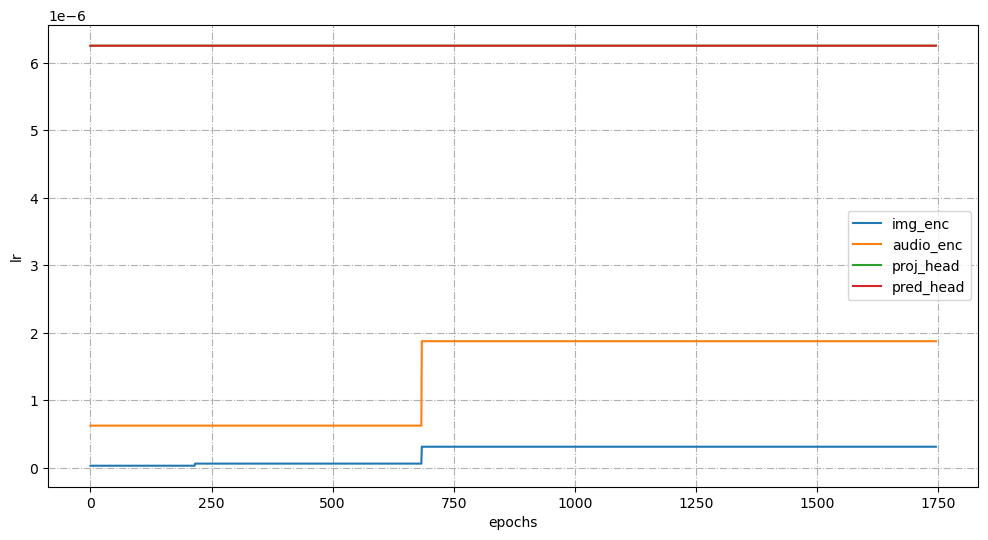

In [63]:
# Plot training history.
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'lr.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'lr'
loss_plot_config['labels'] = [key for key in performance_log['lr'].keys()]
data_list = [performance_log['lr'][key] for key in performance_log['lr'].keys()]
utils.save_plot(data_list, loss_plot_config)

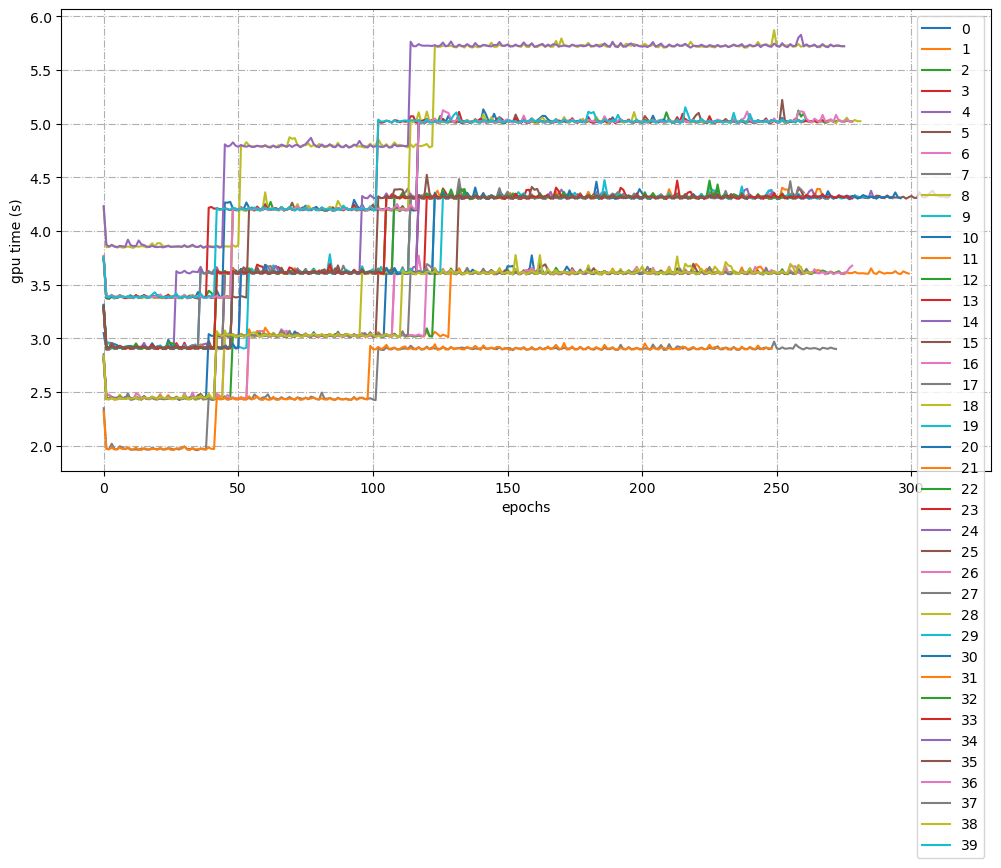

In [64]:
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'gpu_time.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'gpu time (s)'
loss_plot_config['labels'] = [client_idx for client_idx in range(CFG.num_clients)]
data_list = [client_log[client_idx]['gpu_time'] for client_idx in range(CFG.num_clients)]
utils.save_plot(data_list, loss_plot_config)

In [65]:
client_time = utils.timeformat(sum(client_log[0]['gpu_time']))
print('client_time:', client_time)

total_time = utils.timeformat(sum([sum(client_log[idx]['gpu_time']) for idx in range(CFG.num_clients)]))
print('total_time:', total_time)

client_time: 00:19:10
total_time: 11:36:19


In [66]:
total_seconds = sum(client_log[0]['gpu_time'])
average = sum(client_log[0]['gpu_time']) / len(client_log[0]['gpu_time']) 

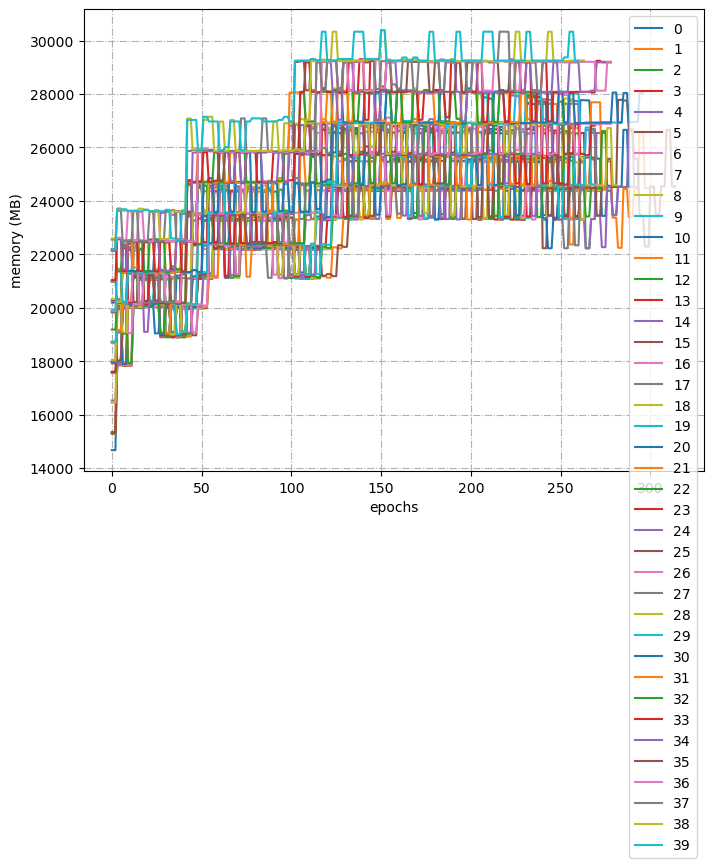

In [67]:
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['save_dir'] = os.path.join(save_dir, 'gpu_mem.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'memory (MB)'
loss_plot_config['labels'] = [client_idx for client_idx in range(CFG.num_clients)]
data_list = [client_log[client_idx]['gpu_mem'] for client_idx in range(CFG.num_clients)]
utils.save_plot(data_list, loss_plot_config)

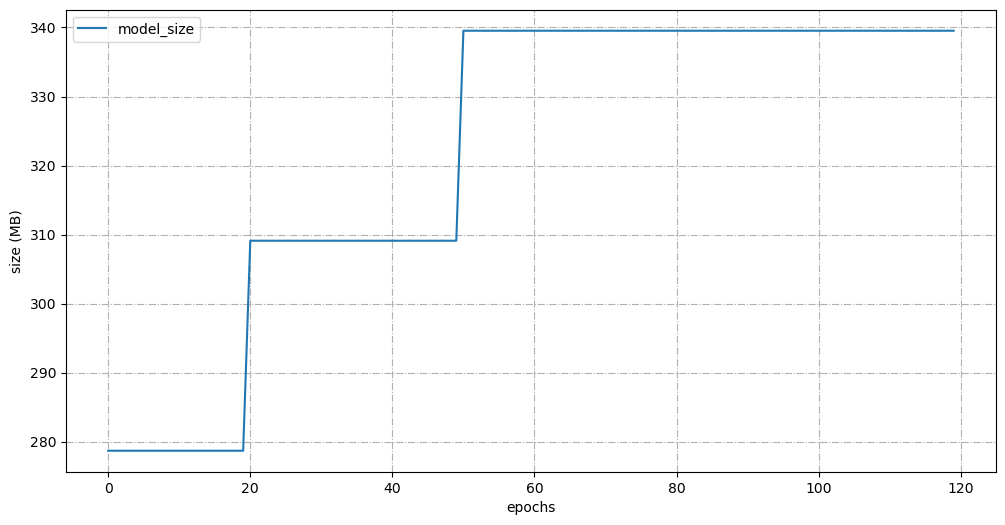

In [68]:
loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['title'] = None
loss_plot_config['figsize'] = (12, 6)
loss_plot_config['save_dir'] = os.path.join(save_dir, 'model_size.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['ylabel'] = 'size (MB)'
loss_plot_config['labels'] = ['model_size']
data_list = [performance_log['model_size']]
utils.save_plot(data_list, loss_plot_config)

In [69]:
cfg_dict = dataclasses.asdict(CFG)
cfg_dict['device'] = cfg_dict['device'].type  # This gets a string since torch.device is not JSON serializable.

cfg_dict['train_acc'] = performance_log['train_acc'][-1]
cfg_dict['test_acc'] = performance_log['test_acc'][-1]

cfg_dict['max_train_acc'] = max(performance_log['train_acc'])
cfg_dict['max_test_acc'] = max(performance_log['test_acc'])

print('train_acc:', cfg_dict['train_acc'])
print('test_acc:', cfg_dict['test_acc'])
print('max_train_acc:', cfg_dict['max_train_acc'])
print('max_test_acc:', cfg_dict['max_test_acc'])

train_acc: 0.9594196428571428
test_acc: 0.9254261363636364
max_train_acc: 0.9629960317460317
max_test_acc: 0.9254261363636364


In [70]:
result_dict = val_sup_advance_metrics(sup_model, val_loader, CFG)
result_dict

100%|██████████| 64/64 [00:15<00:00,  4.07it/s]


{'precision': 0.6984375021420419,
 'recall': 0.6722182822413743,
 'f1': 0.6833597382064909,
 'acc': 0.9293323867022991}

In [71]:
cfg_dict['final_test_acc'] = result_dict['acc']
cfg_dict['precision'] = result_dict['precision']
cfg_dict['recall'] = result_dict['recall']
cfg_dict['f1'] = result_dict['f1']

In [72]:
client_time = utils.timeformat(sum(client_log[0]['gpu_time']))
total_time = utils.timeformat(sum([sum(client_log[idx]['gpu_time']) for idx in range(CFG.num_clients)]))
max_gpu_mem = str(max(client_log[0]['gpu_mem'])) + ' MB'

print('client_time:', client_time)
print('total_time:', total_time)
print('max_gpu_mem:', max_gpu_mem)

cfg_dict['client_time'] = client_time
cfg_dict['total_time'] = total_time
cfg_dict['max_gpu_mem'] = max_gpu_mem

utils.save_dict_json(os.path.join(save_dir, 'note.json'), cfg_dict)

client_time: 00:19:10
total_time: 11:36:19
max_gpu_mem: 27769 MB
